# Data Dimensionality

Note that the parameters parse_dates and infer_datetime_format are needed only if the data has some datetime variables.

In [21]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import ds_charts as ds
from ds_charts import get_variable_types
from pandas.plotting import register_matplotlib_converters
from datetime import datetime

%run p00_settings.ipynb

In [22]:
register_matplotlib_converters()

data = read_csv(project_path + data_file, index_col=time_var, sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)
data.drop(columns=drop_vars, inplace= True)
data.shape

(11193, 4)

In the presence of missing values, is important to define the symbol used to represent them in the datafile, using the na_values parameter.

The next thing we need to do is to understand the ratio between the number of records and variables.

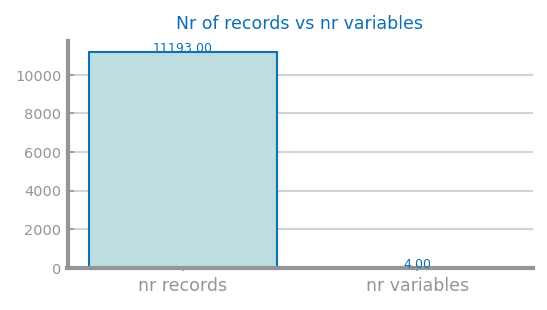

In [23]:
plt.figure(figsize=(4,2))
values = {'nr records': data.shape[0], 'nr variables': data.shape[1]}
ds.bar_chart(list(values.keys()), list(values.values()), title='Nr of records vs nr variables')
plt.savefig(project_path + '03_images/records_variables.png')
plt.show()

Note that function save_fig saves the figure in a png file named records_variables in folder images, which has to exist in the working directory.

## Variables Type

As you know, the different types of variables require different treatments. dtypes returns the types of all variables in the dataframe.

In [24]:
data.dtypes

 Open     float64
 High     float64
 Low      float64
 Close    float64
dtype: object

If we need to apply any function that only deals with symbolic variables, we need to transform object variables into category ones (the name for symbolic in pandas).

In [25]:
cat_vars = data.select_dtypes(include='object')
data[cat_vars.columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
data.dtypes

 Open     float64
 High     float64
 Low      float64
 Close    float64
dtype: object

But we can go further ahead and write a function to collect the names of variables for each different type. It receives the dataframe to analyse and returns a dictionary with a list of column names for types numeric, binary, symbolic and date.

In [26]:
from numpy import isnan,datetime64
from datetime import datetime

def get_variable_types(df):
    NR_SYMBOLS = 10
    variable_types = {'binary': [], 'numeric': [], 'date': [], 'symbolic': []}
    for c in df.columns:
        mv = df[c].isna().sum()
        uniques = df[c].unique()

        if mv == 0:
            if len(uniques) == 2:
                variable_types['binary'].append(c)
                df[c].astype('bool')
            elif df[c].dtype == 'datetime64[ns]':
                variable_types['date'].append(c)
            elif len(uniques) < NR_SYMBOLS:
                df[c].astype('category')
                variable_types['symbolic'].append(c)
            elif str(df[c].dtype) == 'category':
                variable_types['symbolic'].append(c)
            else:
                variable_types['numeric'].append(c)
        else:
            uniques = [v for v in uniques if not pd.isnull(v)]
            values = [v for v in uniques if isinstance(v,str)]
            if len(uniques) == 2:
                variable_types['binary'].append(c)
            elif len(values) == len(uniques):
                df[c].astype('category')
                variable_types['symbolic'].append(c)
            else:
                values = [v for v in uniques if isinstance(v, datetime64)]
                if len(values) == len(uniques):
                    variable_types['date'].append(c)
                else:
                    variable_types['numeric'].append(c)
    return variable_types

Showing and saving the chart is just a plus.

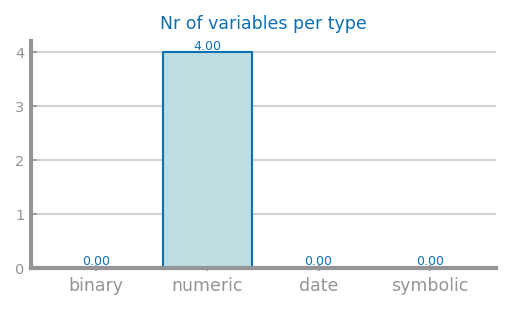

In [27]:
variable_types = get_variable_types(data)
counts = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])
plt.figure(figsize=(4,2))
ds.bar_chart(list(counts.keys()), list(counts.values()), title='Nr of variables per type')
plt.savefig(project_path + '03_images/variable_types.png')
plt.show()

## Missing values

With the previous function is then easy to see how many missing values there are for each variable.

In [28]:
mv = {}
plt.figure()
for var in data:
    nr = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

if mv:
    ds.bar_chart(list(mv.keys()), list(mv.values()), title='Nr of missing values per variable',xlabel='variables', ylabel='nr missing values', rotation=True)
    plt.savefig(project_path + '03_images/mv.png')
    plt.show()
else:
    print('No missing values')

No missing values


<Figure size 600x450 with 0 Axes>

Note that in the missing values relate to the first observation of each stock (30 stocks = 30 mv's), since last week returns don't exist.

## Data Distribution

After loading the data, and understanding the variables we have available to describe the records, we proceed with the distribution analysis for each variable by itself, non relating them with each other.

Depending on being numeric or symbolic, we can apply a set of different functions to explore their nature. Lets start with the numeric ones.

## Numeric Variables
The simplest way to describe each numeric variable is through its five-number summary, inspecting its range through the identification of its minimum and maximum values, along with other estimators, like the mean, mode, standard deviation and other different percentiles.

In dataframes, we can access it through the describe function. It receives the include parameter with numeric as the default value, meaning that without changing it explicitly, only numeric variables are shown.

In [29]:
data.describe()

,Open,High,Low,Close
count,11193.000000,11193.000000,11193.000000,11193.000000
mean,1111.664717,1118.094523,1104.527947,1111.756219
std,989.819660,995.018417,984.064326,989.857426
min,86.900000,87.520000,86.450000,86.900000
25%,306.750000,308.270000,304.850000,306.750000
50%,1000.420000,1008.770000,991.970000,1002.210000
75%,1422.000000,1430.280000,1412.400000,1422.180000
max,4804.510000,4818.620000,4780.040000,4796.560000


Keep a moment to analyse the count row showing the number of non-missing values for each variable.

The five-numbers summary alone, give all the information required, but it's not easy to interpret. A better way to understand the impact of such values is through the analysis of boxplots for each variable. Again the DataFrame object provides several functions to explore the data, in particular the boxplot function, which plots all numeric variables in the same chart.

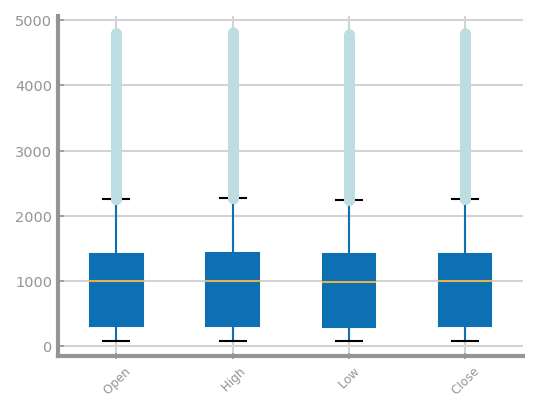

In [30]:
data.boxplot(rot=45)
plt.savefig(project_path + '03_images/global_boxplot.png')
plt.show()

Despite the ability to see the relations among the different ranges for all variables, it is difficult to analyze each one in particular, due to the different scales.

In order to address this difference, we can plot singular boxplots for each variable using boxplot methods from matplotlib. In order to show the best plots, we can use our get_variable_types function to select the variables for each type, and then explore them alone.

In [31]:
variable_types = get_variable_types(data)
numeric_vars = variable_types['numeric']

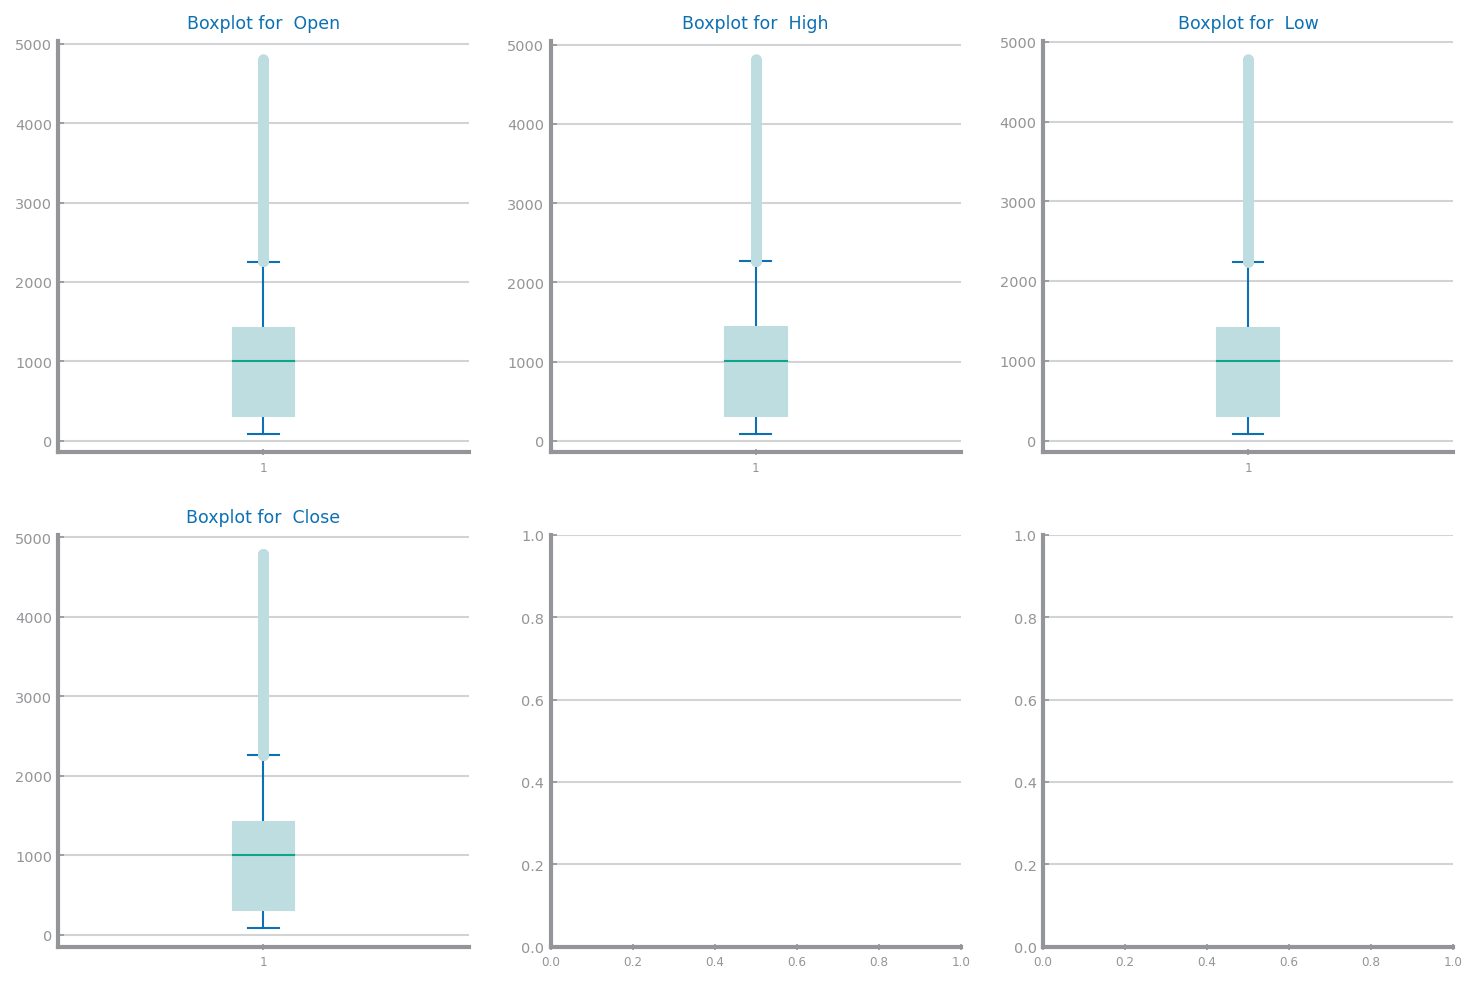

In [32]:
if numeric_vars:
    rows, cols = ds.choose_grid(len(numeric_vars))
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title('Boxplot for %s'%numeric_vars[n])
        axs[i, j].boxplot(data[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    plt.savefig(project_path + '03_images/single_boxplots.png')
    plt.show()
else:
    print('No numeric vars')

From the boxplots, it's clear that our variables have different ranges, scales, that there are several outliers, but we are not able to know anything else about the variables distribution. In order to see their distribution the best option is to plot the histogram for each numeric variable, through the use of hist method.

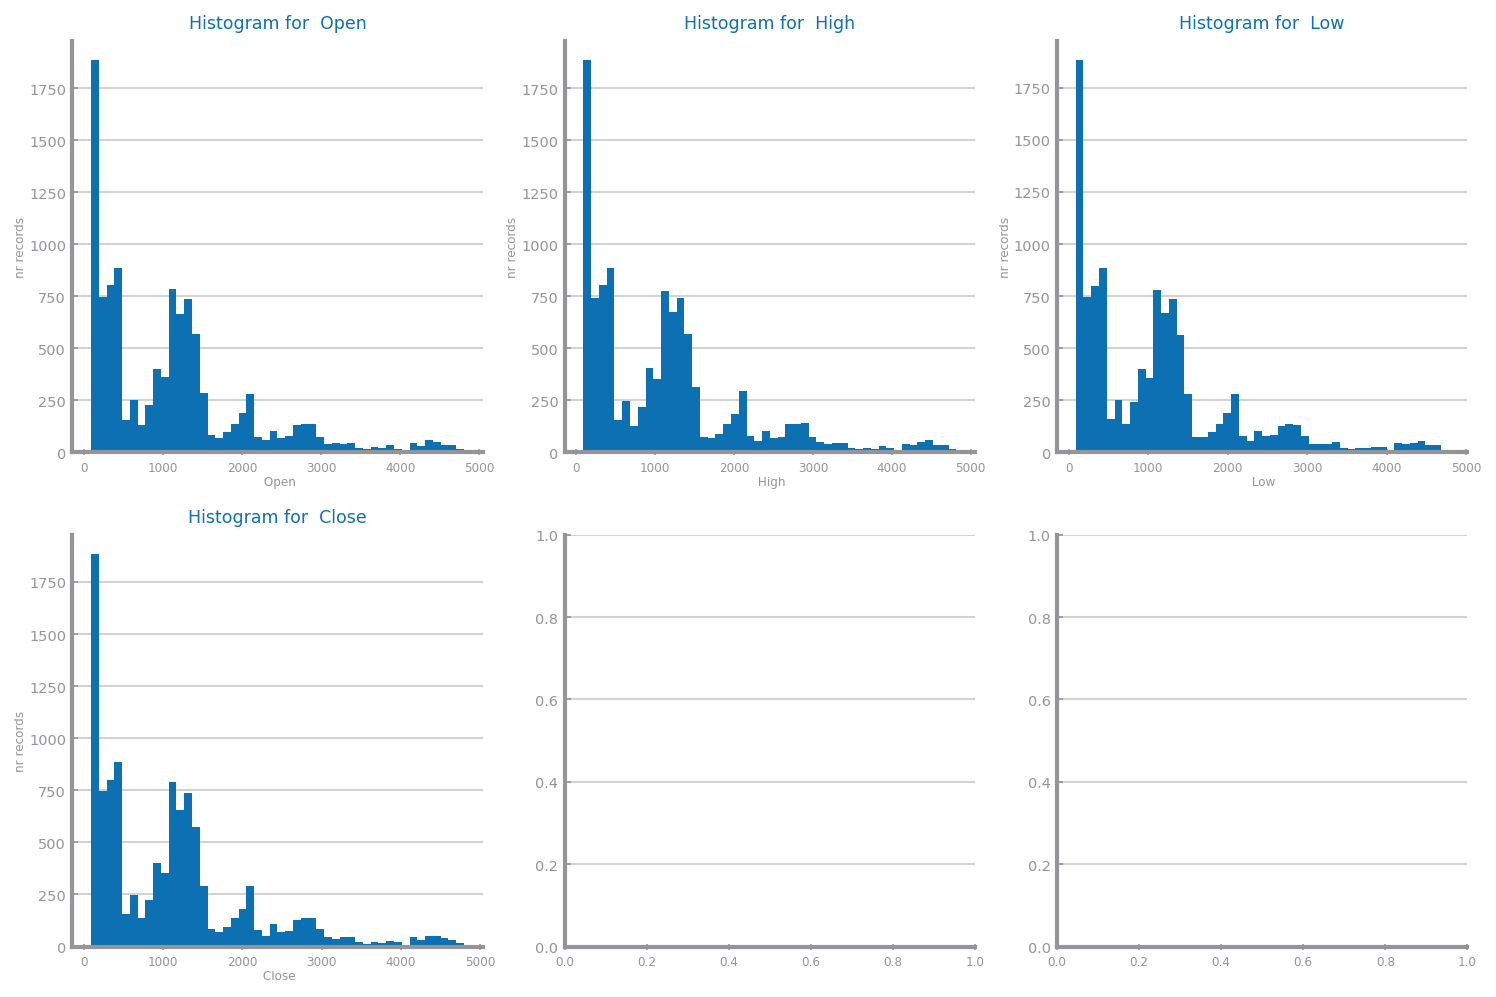

In [33]:
if numeric_vars:
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title('Histogram for %s'%numeric_vars[n])
        axs[i, j].set_xlabel(numeric_vars[n])
        axs[i, j].set_ylabel("nr records")
        axs[i, j].hist(data[numeric_vars[n]].dropna().values, 'auto')
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    plt.savefig(project_path + '03_images/single_histograms_numeric.png')
    plt.show()
else:
    print('No numeric vars')

Indeed histograms give us an insight about the distribution of each variable, but recognizing the distribution that best fits the data may be hard. Seaborn provides the distplot method to display the best fit for the variable.

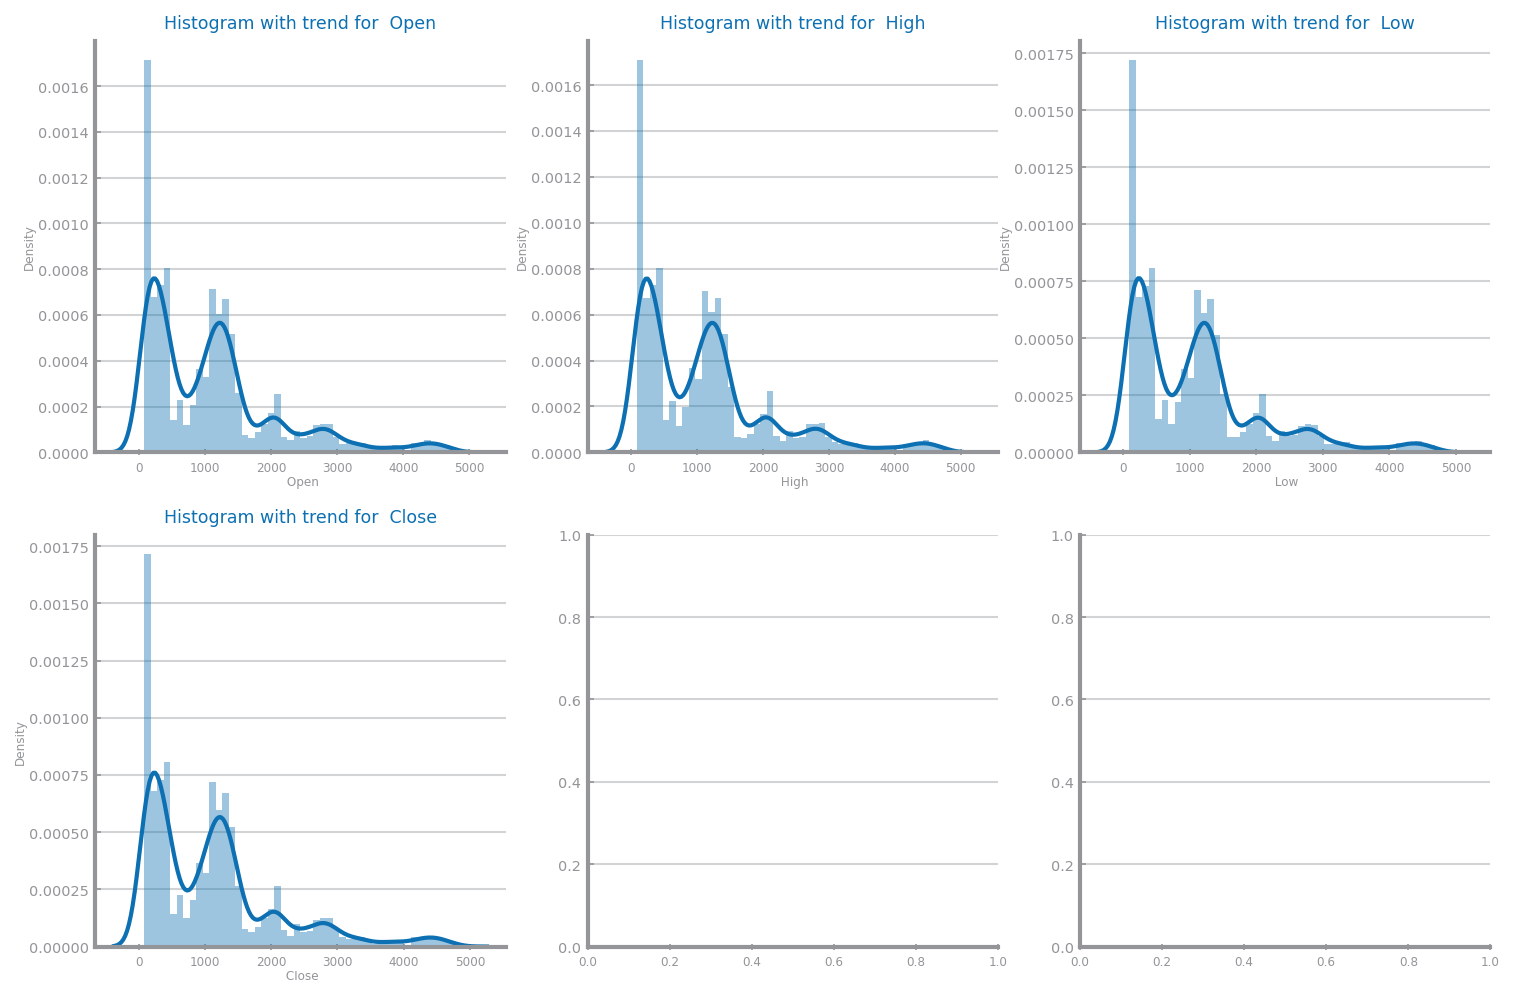

In [34]:
import seaborn as sns

if numeric_vars:
    rows, cols = ds.choose_grid(len(numeric_vars))
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title('Histogram with trend for %s'%numeric_vars[n])
        sns.distplot(data[numeric_vars[n]].dropna().values, norm_hist=True, ax=axs[i, j], axlabel=numeric_vars[n])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    plt.savefig(project_path + '03_images/histograms_trend_numeric.png')
    plt.show()
else:
    print('No numeric vars')

Despite the simplicity of this approach, we are not able to verify how much standard distributions fit to the data. In order to do that, we can try to fit different known distributions to it, using scipy.stats package functionalities to compute distributions (norm, expon, skewnorm, etc).

In [35]:
import scipy.stats as _stats
import numpy as np

def compute_known_distributions(x_values: list) -> dict:
    distributions = dict()
    # Gaussian
    mean, sigma = _stats.norm.fit(x_values)
    distributions['Normal(%.1f,%.2f)'%(mean,sigma)] = _stats.norm.pdf(x_values, mean, sigma)
    # Exponential
    loc, scale = _stats.expon.fit(x_values)
    distributions['Exp(%.2f)'%(1/scale)] = _stats.expon.pdf(x_values, loc, scale)
    # LogNorm
    sigma, loc, scale = _stats.lognorm.fit(x_values)
    distributions['LogNor(%.1f,%.2f)'%(np.log(scale),sigma)] = _stats.lognorm.pdf(x_values, sigma, loc, scale)
    return distributions

def histogram_with_distributions(ax: plt.Axes, series: pd.Series, var: str):
    values = series.sort_values().values
    ax.hist(values, 20, density=True)
    distributions = compute_known_distributions(values)
    ds.multiple_line_chart(values, distributions, ax=ax, title='Best fit for %s'%var, xlabel=var, ylabel='')

if numeric_vars:
    rows, cols = ds.choose_grid(len(numeric_vars))
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        histogram_with_distributions(axs[i, j], data[numeric_vars[n]].dropna(), numeric_vars[n])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    plt.savefig(project_path + '03_images/histogram_numeric_distribution.png')
    plt.show()
else:
    print('No numeric vars')

## Symbolic Variables

Symbolic variable is the stock ticker, so no need to evaluate it.

## Granularity

The granularity at which we analyze each variable also plays a fundamental role. Indeed, when we plot the histogram for each variable, we have to determine the number of bins used to discretize the data. Until now, we used automatic choice for it through nbins='auto').

Let's start by plotting an histogram with the 100 bins:

In [16]:
binary_vars = variable_types['binary']

if binary_vars:
    rows, cols = ds.choose_grid(len(binary_vars))
    if rows == cols == 1:
        plt.title('Histogram for %s'%binary_vars[n])
        plt.xlabel(binary_vars[n])
        plt.ylabel('nr records')
        plt.hist(data[binary_vars[n]].values)
    else:
        fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
        i, j = 0, 0
        for n in range(len(binary_vars)):
            axs[i, j].set_title('Histogram for %s'%binary_vars[n])
            axs[i, j].set_xlabel(binary_vars[n])
            axs[i, j].set_ylabel('nr records')
            axs[i, j].hist(data[binary_vars[n]].values)
            i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    plt.savefig(project_path + '03_images/granularity_single_binary.png')
    plt.show()
else:
    print('No binary variables')

No binary variables


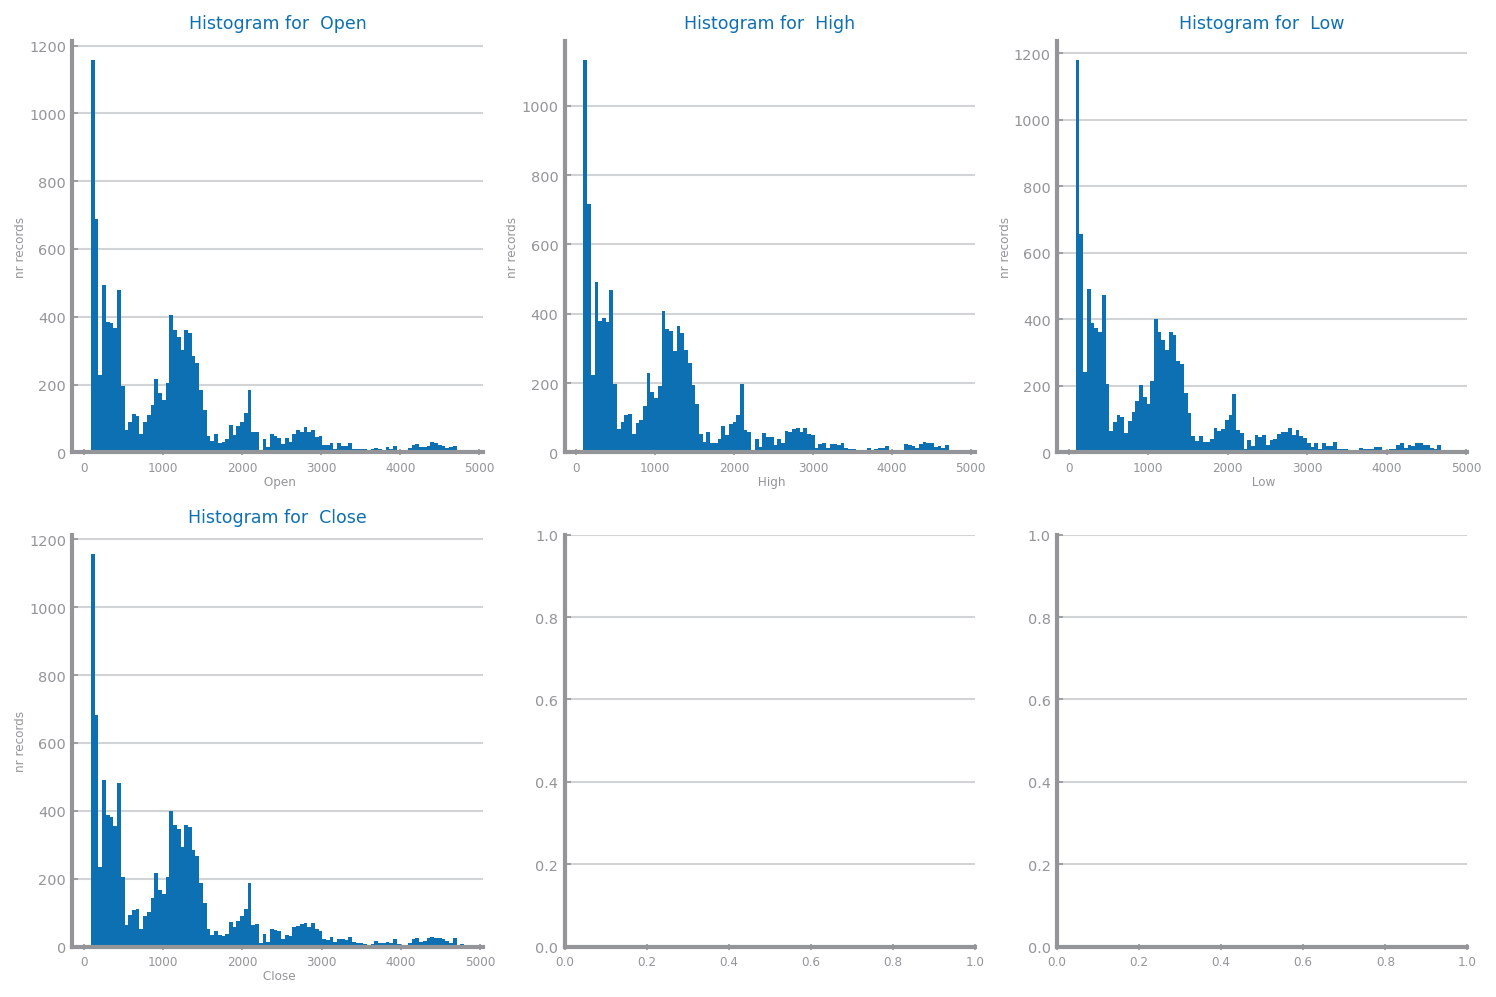

In [17]:
if numeric_vars:
    rows, cols = ds.choose_grid(len(numeric_vars))
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title('Histogram for %s'%numeric_vars[n])
        axs[i, j].set_xlabel(numeric_vars[n])
        axs[i, j].set_ylabel('nr records')
        axs[i, j].hist(data[numeric_vars[n]].values, bins=100)
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    plt.savefig(project_path + '03_images/granularity_single.png')
    plt.show()
else:
    print('No numeric variables')

We have set the number of bins to 100, but this number has a direct impact on the shape presented, since it reveals the level of granularity considered. Indeed, we may consider other levels of detail, and in order to do that, we try setting the number of bins to different values.

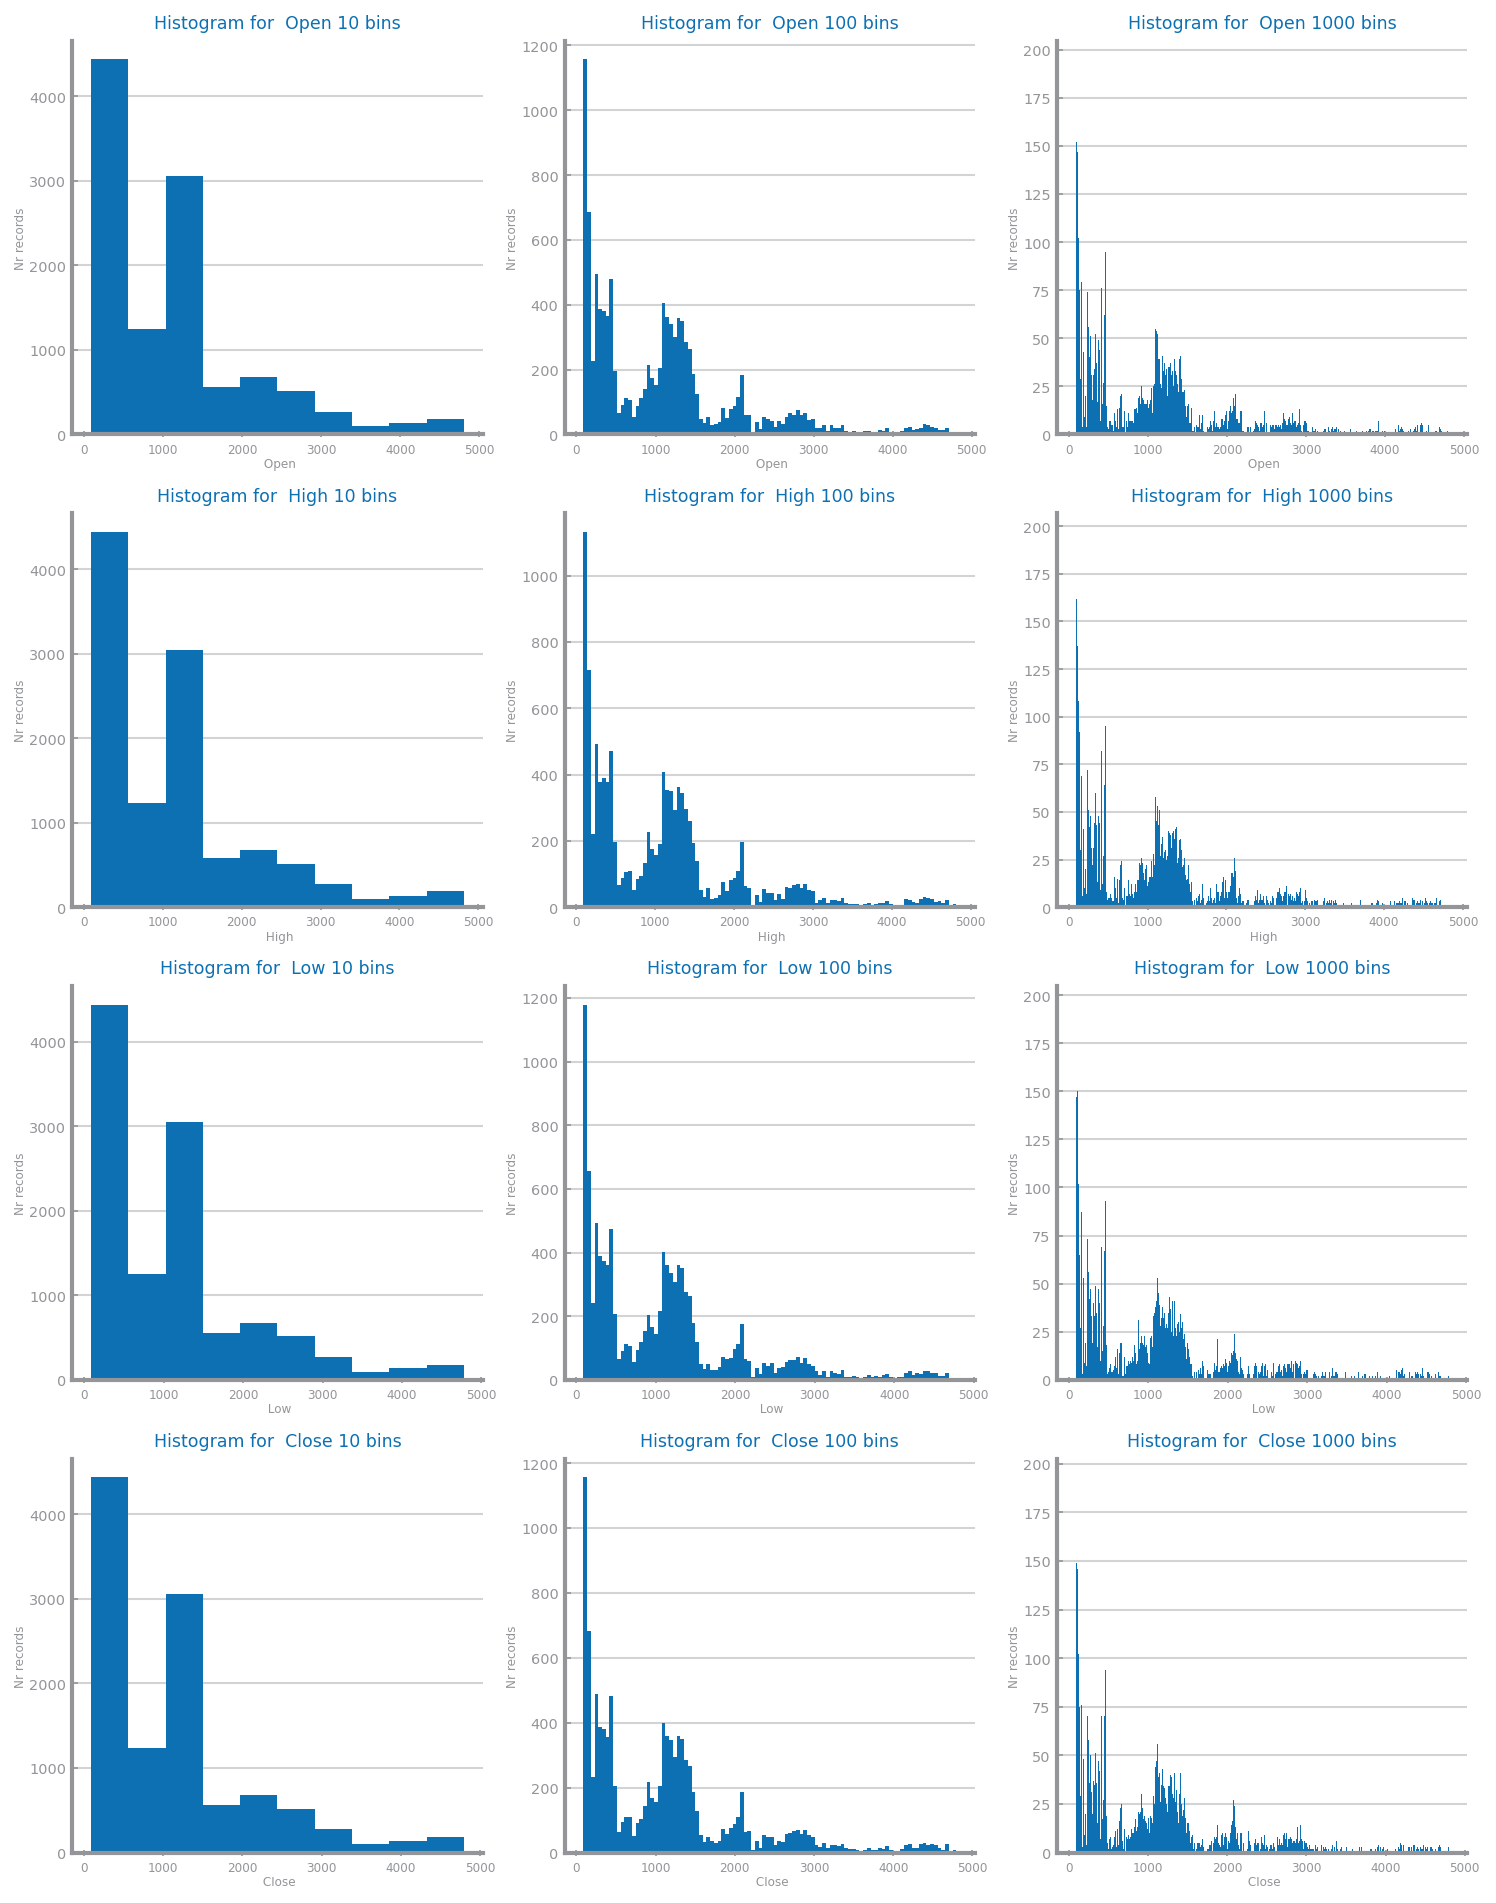

In [18]:
if numeric_vars:
    rows = len(numeric_vars)
    bins = (10, 100, 1000)
    cols = len(bins)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
    for i in range(rows):
        for j in range(cols):
            axs[i, j].set_title('Histogram for %s %d bins'%(numeric_vars[i], bins[j]))
            axs[i, j].set_xlabel(numeric_vars[i])
            axs[i, j].set_ylabel('Nr records')
            axs[i, j].hist(data[numeric_vars[i]].values, bins=bins[j])
    plt.savefig(project_path + '03_images/granularity_study.png')
    plt.show()
else:
    print('No numeric variables')

# Sparsity
The last of analysis perspectives is the sparsity analysis, which encompasses the exploration of the domain coverage, in a multi-variate way. This is done through the cross analysis of the records projected according to just a few of its variables (usually only two). In practice, these projections are achieved through bidimensional charts, visualizing one variable against another.

## Sparsity
A dataset is said to be sparse when most of the space defined by its variables is not covered by the records in the dataset. A way to have some insight over the sparsity of data is to use scatter plots to project the data along two of its defining variables. To do it, we can use the scatter method.

Note that boolean variables show at most 4 points for any pair of boolean variables, meaning that it is difficult to get any information from scatter plots for them.

<Figure size 600x450 with 0 Axes>

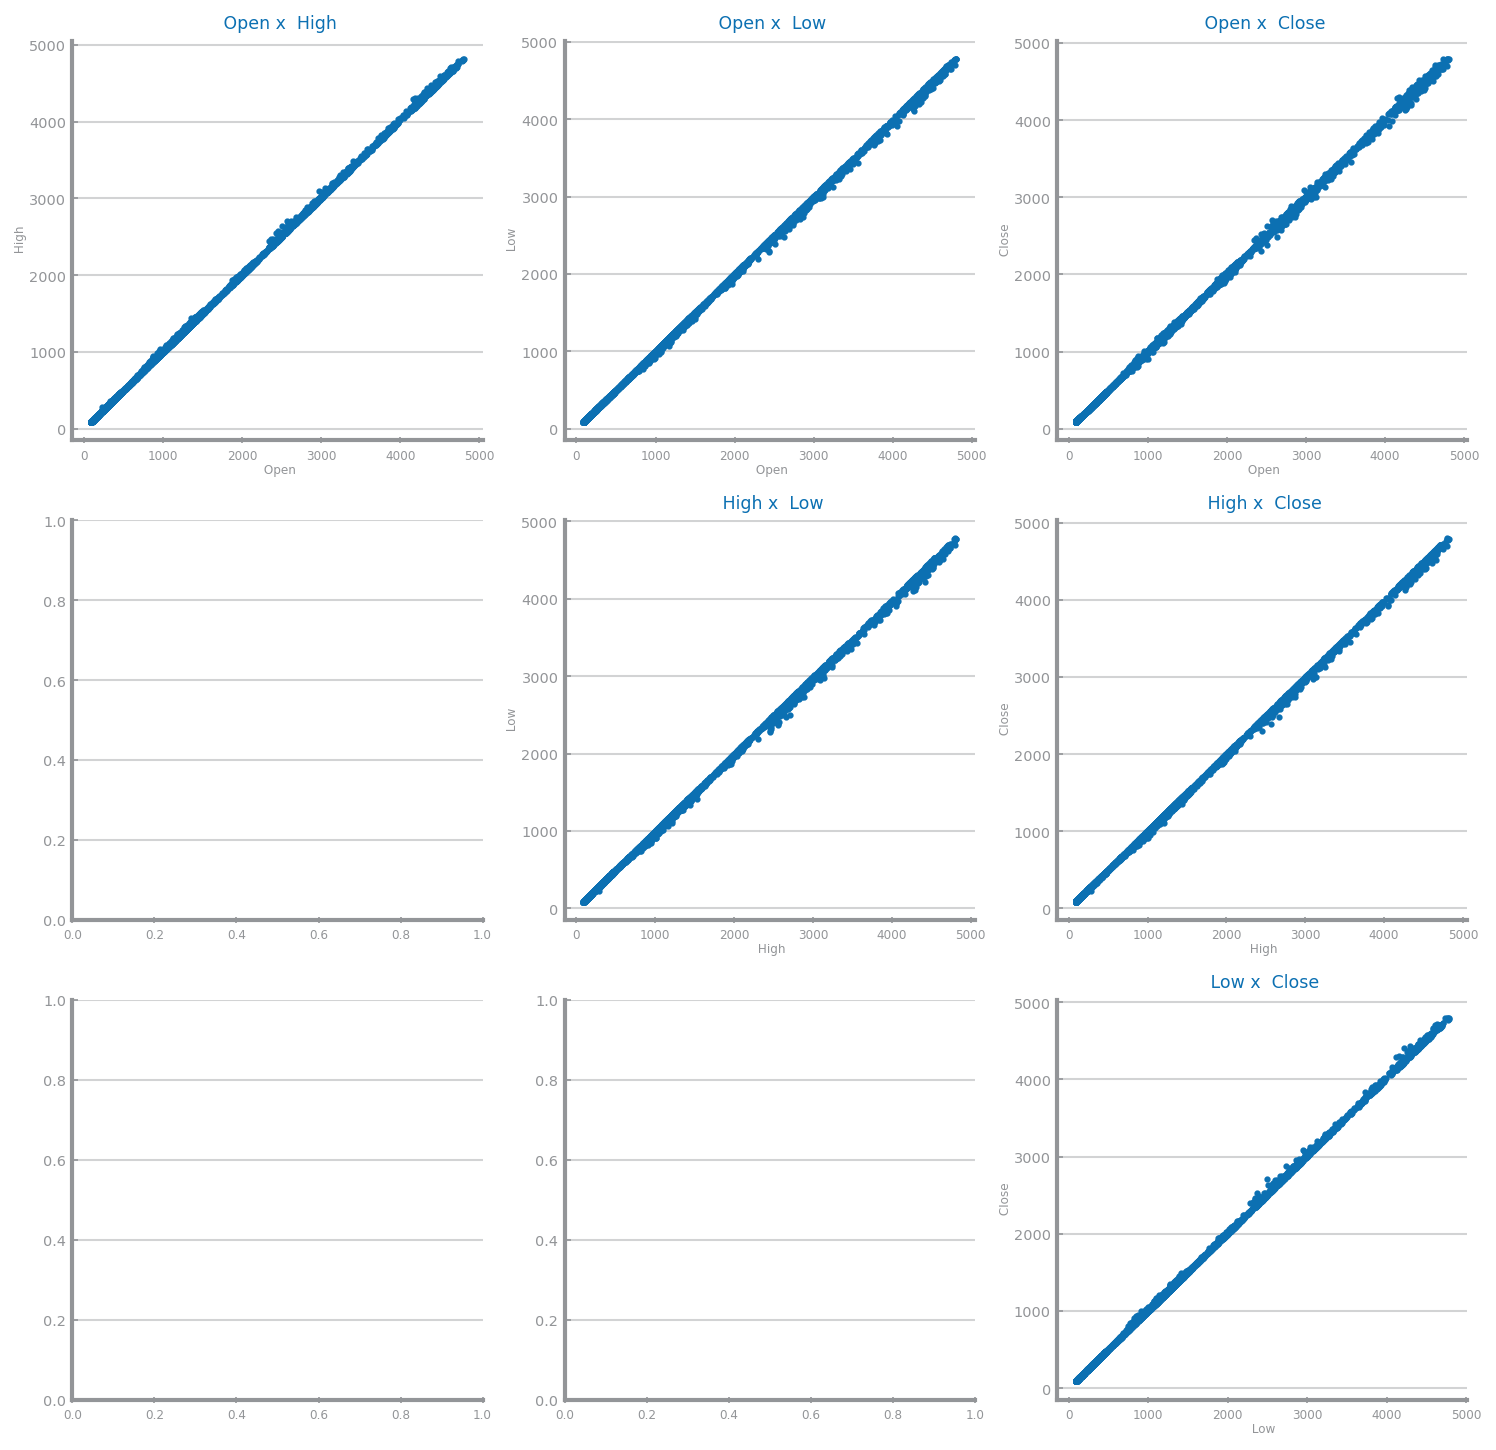

In [19]:
if numeric_vars:
    rows, cols = len(numeric_vars)-1, len(numeric_vars)-1
    plt.figure()
    fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4), squeeze=False)
    for i in range(len(numeric_vars)):
        var1 = numeric_vars[i]
        for j in range(i+1, len(numeric_vars)):
            var2 = numeric_vars[j]
            axs[i, j-1].set_title("%s x %s"%(var1,var2))
            axs[i, j-1].set_xlabel(var1)
            axs[i, j-1].set_ylabel(var2)
            axs[i, j-1].scatter(data[var1], data[var2])
    plt.savefig(project_path + f'03_images/sparsity_study_numeric.png')
    plt.show()
else:
    print('No numeric variables')

## Correlation analysis
Despite showing data sparsity, scatter plots are also useful for showing the correlation among variables. However, in the presence of a large dimensionality, a heatmap is easier to analyze. To do it, we can use the heatmap from the seaborn package.

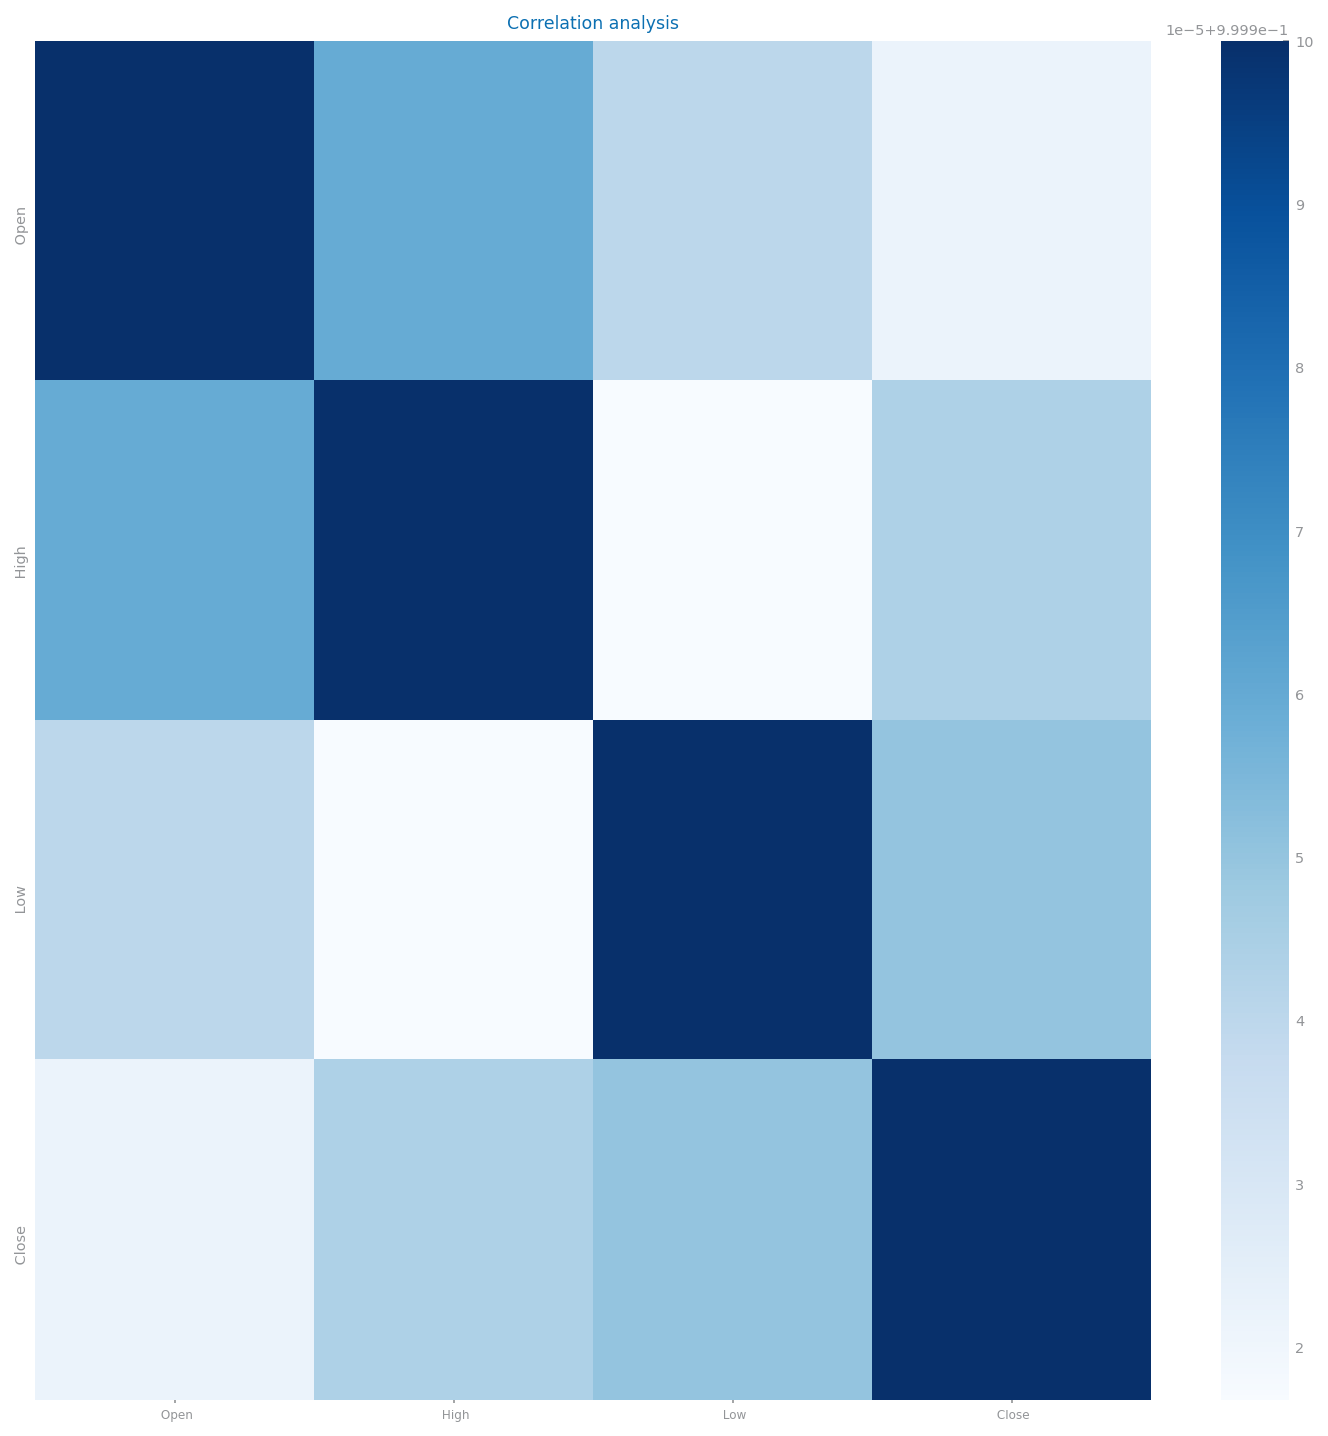

In [20]:
fig = plt.figure(figsize=[12, 12])
corr_mtx = data.corr()

#For an high number of features:
# plt.matshow(corr_mtx)
# plt.colorbar()

#For low number of features:
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=False, cmap='Blues')
plt.title('Correlation analysis')

plt.savefig(project_path + '03_images/correlation_analysis.png')
plt.show()